# Machine Learning in High Dimension

# Naive Bayes

The objective of this lab is to test **Naive Bayes** for classification in high dimension.

This lab is graded and must be uploaded on Moodle in due time.

## Instructions

* You can work alone or in a team of 2.
* Indicate your name(s) here: Mohamed Aymen BOUYAHIA
* Do not import any other library (except ``scipy``, ``pandas``, ``seaborn``, if necessary).
* Do not copy-paste any code or text from other students / teams.
* Be concise in your answers.
* Use at most one figure or table per question.
* Make sure that your notebook runs without errors.
* Save your notebook with the figures / tables.
* Upload your notebook on Moodle (one per team).

## Imports

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

## Datasets



We consider the datasets: [MNIST](https://en.wikipedia.org/wiki/MNIST_database), [Wikivitals](https://netset.telecom-paris.fr/pages/wikivitals.html), [German credit](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)).


In [18]:
with open('data.p', 'br') as f:
    data = pickle.load(f)

In [19]:
X_train, X_test, y_train, y_test = data['mnist']

In [20]:
def display_samples(X, n_rows=10, n_cols=10, size_pix=28, margin_pix=1):
    """Display a grid of samples of the MNIST dataset."""
    n_pix = size_pix + 2 * margin_pix
    n = X.shape[0]
    if n < n_rows * n_cols:
        n_rows = n // n_cols + 1
        samples = np.arange(n)
    else:
        samples = np.random.choice(n, size=n_rows * n_cols, replace=False)
    img = np.zeros((n_rows * n_pix, n_cols * n_pix))
    for i in range(n_rows):
        i_pix = i * n_pix
        for j in range(n_cols):
            j_pix = j * n_pix
            if i*n_cols + j < len(samples):
                k = samples[i*n_cols + j]
                img[i_pix: i_pix+size_pix, j_pix: j_pix+size_pix] = X[k].reshape((size_pix, size_pix))
    plt.imshow(img, cmap='binary')
    plt.axis('off')
    plt.show()

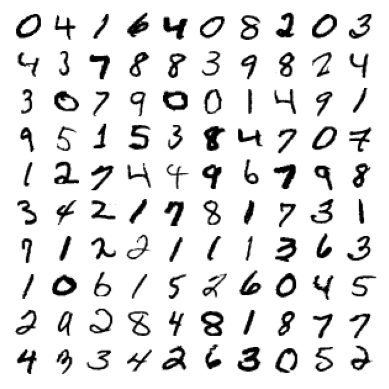

In [21]:
display_samples(X_train)

In [13]:
with open('meta_data.p', 'br') as f:
    meta_data = pickle.load(f)

In [22]:
articles_train, articles_test, words, names_labels = meta_data['wikivitals']
print(articles_train)
print(articles_test)
print(words)
print(len(names_labels))

['0' '14th Dalai Lama' '1556 Shaanxi earthquake' ... 'Ānanda' 'Łódź' '−1']
['1' '100 metres' '1989 Tiananmen Square protests' ... 'Émile Durkheim'
 'İzmir' 'Śāriputra']
['Alexis' 'Cairo' 'subordinate' ... 'parody' 'martyrdom' 'Wyler']
11


In [23]:
columns = meta_data['credit']
print(columns)

['Duration_of_Credit_monthly', 'Credit_Amount', 'Instalment_per_cent', 'Guarantors', 'Duration_in_Current_address', 'No_of_Credits_at_this_Bank', 'No_of_dependents', 'Length_of_current_employment_1', 'Length_of_current_employment_2', 'Length_of_current_employment_3', 'Length_of_current_employment_4', 'Length_of_current_employment_5', 'Purpose_0', 'Purpose_1', 'Purpose_2', 'Purpose_3', 'Purpose_4', 'Purpose_5', 'Purpose_6', 'Purpose_8', 'Purpose_9', 'Purpose_10', 'Concurrent_Credits_1', 'Concurrent_Credits_2', 'Concurrent_Credits_3', 'Sex_Marital_Status_1', 'Sex_Marital_Status_2', 'Sex_Marital_Status_3', 'Sex_Marital_Status_4', 'Type_of_apartment_1', 'Type_of_apartment_2', 'Type_of_apartment_3', 'Telephone_1', 'Telephone_2', 'Most_valuable_available_asset_1', 'Most_valuable_available_asset_2', 'Most_valuable_available_asset_3', 'Most_valuable_available_asset_4', 'Account_Balance_1', 'Account_Balance_2', 'Account_Balance_3', 'Account_Balance_4', 'Value_Savings_Stocks_1', 'Value_Savings_S

## To do

We first assess the efficiency of Naive Bayes.
Please be concise in your answers.

* Compare the accuracy of the classification by Naive Bayes (Bernoulli, Multinomial, Gaussian) to k-nearest neighbors for each dataset.<br>**Note:** For Wikivitals, skip the Gaussian model as it is not applicable to sparse data.
* For the MNIST dataset under the Multinomial model, explain the results using the classification report.
* For the German credit dataset, compare the results with and without the numerical features.
* For the Wikivitals dataset under the Multinomial model, compare the accuracy of the classification of the 100 articles of the test set classified with the highest confidence to that of the 100 articles of the test set classified with the lowest confidence.<br> **Hint:** Use the predicted probabilities.
* For the Wikivitals dataset under the Multinomial model, sample 100 words about Mathematics, according to the distribution learned by the statistical model. What do you observe?

In [24]:
import seaborn as sns
import pandas as pd

In [25]:
CLASSIFIERS = [KNeighborsClassifier(n_neighbors=5, metric='cosine'),
               BernoulliNB(),
               MultinomialNB(),
               GaussianNB()]

In [39]:
def get_score(algo, dataset_name):         #This function calculate the accuracy of the model
    X_train, X_test, y_train, y_test = data[dataset_name]
    if dataset_name == "credit":
        # scaling, useful only for nearest neighbors

        if algo.__class__.__name__ == 'KNeighborsClassifier':
            scaler = MaxAbsScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

    elif dataset_name == "wikivitals":
        X_train = (X_train > 0).astype(int)
        X_test = (X_test > 0).astype(int)

    algo.fit(X_train, y_train)
    return algo.score(X_test, y_test)     #the function score() returns the accuracy of the algo

In [41]:
results = []
for dataset_name in ["credit", "mnist", "wikivitals"]:
    print("-----")
    print(f"Dataset {dataset_name}")
    for classifier in CLASSIFIERS:
        classifier_name = classifier.__class__.__name__
        print("Doing {}".format(classifier_name, dataset_name))
        if classifier_name =='GaussianNB' and dataset_name=="wikivitals":
            results.append([dataset_name, classifier_name, float("nan")])
        else:
            score = get_score(classifier, dataset_name)
            results.append([dataset_name, classifier_name, score])
            if classifier_name =='MultinomialNB' and dataset_name=="mnist":
                X_train, X_test, y_train, y_test = data[dataset_name]
                cr = classification_report(y_test,classifier.predict(X_test))

-----
Dataset credit
Doing LogisticRegression
Doing BernoulliNB
Doing MultinomialNB
Doing GaussianNB
-----
Dataset mnist
Doing LogisticRegression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Doing BernoulliNB
Doing MultinomialNB
Doing GaussianNB
-----
Dataset wikivitals
Doing LogisticRegression
Doing BernoulliNB
Doing MultinomialNB
Doing GaussianNB


In [38]:
print(results)

[['credit', 'LogisticRegression', 0.7842323651452282], ['credit', 'BernoulliNB', 0.7344398340248963], ['credit', 'MultinomialNB', 0.6224066390041494], ['credit', 'GaussianNB', 0.7261410788381742], ['mnist', 'LogisticRegression', 0.845], ['mnist', 'BernoulliNB', 0.809], ['mnist', 'MultinomialNB', 0.807], ['mnist', 'GaussianNB', 0.554], ['wikivitals', 'LogisticRegression', 0.8784], ['wikivitals', 'BernoulliNB', 0.7408], ['wikivitals', 'MultinomialNB', 0.8168], ['wikivitals', 'GaussianNB', nan]]


Score of the different methods on the different datasets

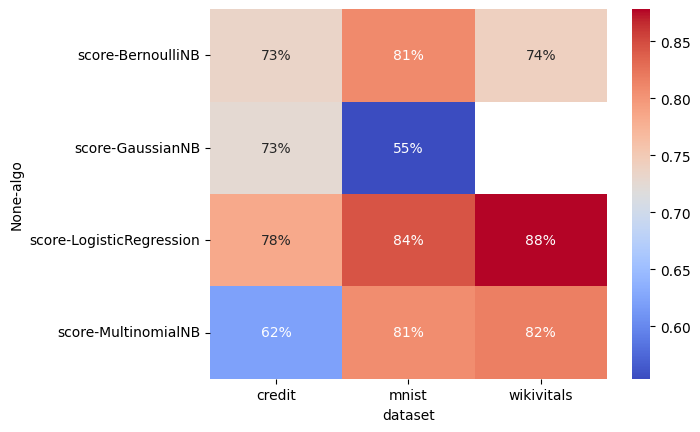

In [42]:
sns.heatmap(
    pd.DataFrame(results, columns=["dataset", "algo", "score"])
          .set_index(["dataset", "algo"])
          .unstack().T,
    cmap = sns.color_palette("coolwarm" ,as_cmap=True),
    annot=True,
    fmt=".0%"
);

Classification report of multinomial classifier on MNIST dataset

In [43]:
print(cr)

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        85
           1       0.91      0.93      0.92       126
           2       0.92      0.80      0.86       116
           3       0.72      0.85      0.78       107
           4       0.86      0.68      0.76       110
           5       0.87      0.62      0.72        87
           6       0.86      0.87      0.87        87
           7       0.91      0.75      0.82        99
           8       0.60      0.72      0.66        89
           9       0.64      0.90      0.75        94

    accuracy                           0.81      1000
   macro avg       0.82      0.80      0.80      1000
weighted avg       0.82      0.81      0.81      1000



German credit with and without numerical features

In [64]:
X_train, X_test, y_train, y_test = data["credit"]
X_train[:,4]

array([4, 2, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 3, 2, 3, 4, 4, 3, 3, 1, 3,
       4, 4, 4, 4, 4, 4, 1, 3, 4, 2, 1, 2, 4, 3, 4, 3, 1, 2, 3, 1, 2, 2,
       1, 4, 4, 3, 4, 2, 3, 4, 1, 2, 2, 1, 4, 2, 1, 4, 2, 4, 2, 3, 1, 4,
       4, 3, 2, 4, 2, 2, 3, 4, 1, 1, 2, 1, 2, 1, 4, 2, 2, 2, 2, 4, 3, 2,
       1, 3, 1, 3, 3, 3, 4, 2, 3, 1, 3, 2, 3, 1, 2, 2, 2, 4, 2, 1, 2, 3,
       3, 2, 4, 4, 4, 3, 4, 4, 4, 4, 3, 2, 3, 1, 2, 2, 4, 4, 2, 4, 2, 2,
       1, 4, 2, 3, 4, 1, 1, 4, 3, 2, 2, 2, 1, 1, 4, 2, 2, 1, 2, 2, 1, 1,
       2, 4, 2, 1, 2, 1, 4, 4, 4, 4, 2, 1, 4, 2, 4, 4, 3, 2, 1, 4, 2, 4,
       2, 1, 4, 3, 4, 2, 4, 3, 4, 2, 4, 4, 3, 2, 3, 3, 4, 4, 4, 3, 4, 2,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 2, 4, 4, 4, 2, 3, 1, 4, 2,
       2, 2, 2, 4, 4, 3, 1, 2, 2, 4, 2, 4, 2, 2, 1, 4, 4, 4, 1, 2, 1, 2,
       2, 2, 3, 2, 4, 3, 2, 2, 2, 4, 4, 1, 4, 3, 2, 2, 2, 4, 2, 4, 4, 2,
       1, 3, 2, 2, 4, 4, 4, 4, 2, 4, 2, 4, 3, 2, 4, 2, 2, 2, 4, 1, 2, 3,
       2, 4, 4, 4, 4, 3, 1, 4, 2, 4, 2, 4, 4, 4, 1,

In [30]:
import copy as cp

In [44]:
results = []
dataset_name = "credit"
X_train, X_test, y_train, y_test = data[dataset_name]
print("-----")
print(f"Dataset {dataset_name}")
for classifier in CLASSIFIERS:
    classifier_name = classifier.__class__.__name__+" with numerical"
    print("Doing {}".format(classifier_name, dataset_name))
    classifier.fit(X_train,y_train)
    score =  classifier.score(X_test, y_test)
    results.append([dataset_name, classifier_name, score])

X_trainCredN = X_train[:,5:]
X_testCredN = X_test[:,5:]
for classifier in CLASSIFIERS:
    classifier_name = classifier.__class__.__name__+" without numerical"
    print("Doing {}".format(classifier_name, dataset_name))
    classifier.fit(X_trainCredN,y_train)
    score = classifier.score(X_testCredN,y_test)
    results.append([dataset_name, classifier_name, score])


-----
Dataset credit
Doing LogisticRegression with numerical
Doing BernoulliNB with numerical
Doing MultinomialNB with numerical
Doing GaussianNB with numerical
Doing LogisticRegression without numerical
Doing BernoulliNB without numerical
Doing MultinomialNB without numerical
Doing GaussianNB without numerical


In [45]:
print(results)

[['credit', 'LogisticRegression with numerical', 0.7842323651452282], ['credit', 'BernoulliNB with numerical', 0.7344398340248963], ['credit', 'MultinomialNB with numerical', 0.6224066390041494], ['credit', 'GaussianNB with numerical', 0.7261410788381742], ['credit', 'LogisticRegression without numerical', 0.7717842323651453], ['credit', 'BernoulliNB without numerical', 0.7344398340248963], ['credit', 'MultinomialNB without numerical', 0.7385892116182573], ['credit', 'GaussianNB without numerical', 0.3651452282157676]]


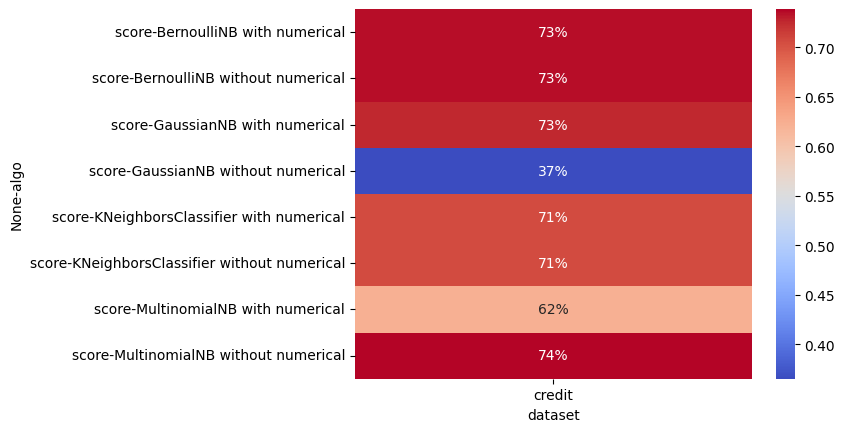

In [32]:
sns.heatmap(
    pd.DataFrame(results, columns=["dataset", "algo", "score"])
          .set_index(["dataset", "algo"])
          .unstack().T,
    cmap = sns.color_palette("coolwarm" ,as_cmap=True),
    annot=True,
    fmt=".0%"
);

Accuracy Wikivitals

In [33]:
def get_importance(algo, dataset_name):
    X_train, X_test, y_train, y_test = data[dataset_name]
    if dataset_name == "credit":
        scaler = MaxAbsScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    elif dataset_name == "wikivitals":
        X_train = (X_train > 0).astype(int)
        X_test = (X_test > 0).astype(int)
    algo.fit(X_train, y_train)
    return algo.feature_importances_

In [34]:
# Wikivitals
X_imp = np.array(list(df["wikivitals"]))
n_imp_features = 30
indices = np.argsort(-X_imp, axis=1)[:, :n_imp_features]
print(words[indices])

NameError: name 'df' is not defined

## To do

We now compare Naive Bayes to another linear classifier, the [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression).

* Compare the accuracy of the classification by Naive Bayes (Bernoulli, Multinomial, Gaussian) to Logisitic regression for each dataset.
* What are the pros and cons of Naive Bayes?

In [35]:
CLASSIFIERS = [LogisticRegression(max_iter=1000),
               BernoulliNB(),
               MultinomialNB(),
               GaussianNB()]

In [36]:
%%time
results = []
for dataset_name in ["credit", "mnist", "wikivitals"]:
    print("-----")
    print(f"Dataset {dataset_name}")
    for classifier in CLASSIFIERS:
        classifier_name = classifier.__class__.__name__
        print("Doing {}".format(classifier_name, dataset_name))
        if classifier_name =='GaussianNB' and dataset_name=="wikivitals":
            results.append([dataset_name, classifier_name, float("nan")])
        else:
            score = get_score(classifier, dataset_name)
            results.append([dataset_name, classifier_name, score])

-----
Dataset credit
Doing LogisticRegression
Doing BernoulliNB
Doing MultinomialNB
Doing GaussianNB
-----
Dataset mnist
Doing LogisticRegression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Doing BernoulliNB
Doing MultinomialNB
Doing GaussianNB
-----
Dataset wikivitals
Doing LogisticRegression
Doing BernoulliNB
Doing MultinomialNB
Doing GaussianNB
CPU times: user 2min 30s, sys: 47.2 s, total: 3min 17s
Wall time: 2min 12s


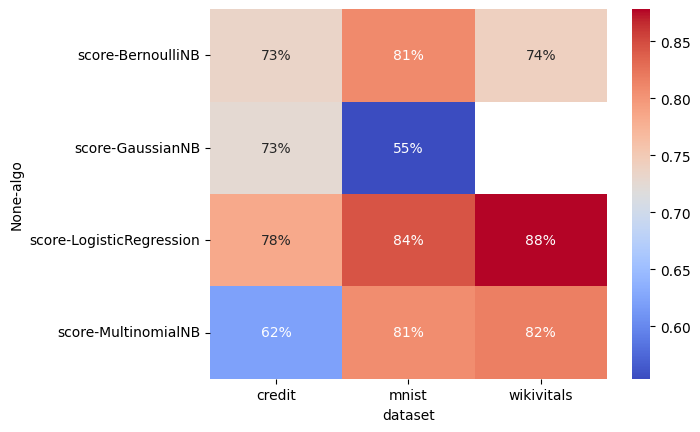

In [37]:
sns.heatmap(
    pd.DataFrame(results, columns=["dataset", "algo", "score"])
          .set_index(["dataset", "algo"])
          .unstack().T,
    cmap = sns.color_palette("coolwarm" ,as_cmap=True),
    annot=True,
    fmt=".0%"
);

Pros and Cons

Naïve Bayes classifiers have some valuable assets. They can be implemented easily, don't need a lot of data, work on continuous and discrete data and is really fast for training and inference. It is also highly scalable and can handle big datasets with a lot of different features. However some issues limit these classifiers. Naïve Bayes in its formulation makes a strong assumption that all the features describing our data are independant from each other which is not true in general, for example, for text data, Naïve Bayes classifiers treat data like a bag of words and doesn't take into account the grammar rules of the text. They also need additionnal smoothing methods to handle the case where a feature has not been seen in the training data, in the baseline case it assigns a probability of 0 to the examined piece of data.